In [1]:
import torch
import torchvision 
from tqdm import tqdm


In [2]:
#如果网络能在GPU中训练，就使用GPU；否则使用CPU进行训练
device = "cuda:0" if torch.cuda.is_available() else "cpu"

#这个函数包括了两个操作：将图片转换为张量，以及将图片进行归一化处理
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])


In [3]:
path = './data/'  #数据集下载后保存的目录

#下载训练集和测试集
trainData = torchvision.datasets.MNIST(path,train = True,transform = transform,download = True)
testData = torchvision.datasets.MNIST(path,train = False,transform = transform)


100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:06<00:00, 1465809.58it/s]


Extracting ./data/MNIST\raw\train-images-idx3-ubyte.gz to ./data/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 31196418.70it/s]


Extracting ./data/MNIST\raw\train-labels-idx1-ubyte.gz to ./data/MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1165474.61it/s]


Extracting ./data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/MNIST\raw



In [4]:
#设定每一个Batch的大小
BATCH_SIZE = 256  

#构建数据集和测试集的DataLoader
trainDataLoader = torch.utils.data.DataLoader(dataset = trainData,batch_size = BATCH_SIZE,shuffle = True)
testDataLoader = torch.utils.data.DataLoader(dataset = testData,batch_size = BATCH_SIZE)


In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.model = torch.nn.Sequential(
            #The size of the picture is 28x28
            torch.nn.Conv2d(in_channels = 1,out_channels = 16,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            #The size of the picture is 14x14
            torch.nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            #The size of the picture is 7x7
            torch.nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            torch.nn.Linear(in_features = 7 * 7 * 64,out_features = 128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features = 128,out_features = 10),
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self,input):
        output = self.model(input)
        return output


In [6]:
trainDataLoader = torch.utils.data.DataLoader(dataset = trainData,batch_size = BATCH_SIZE,shuffle = True)
testDataLoader = torch.utils.data.DataLoader(dataset = testData,batch_size = BATCH_SIZE)

In [7]:
net = Net()
print(net.to(device))

Net(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3136, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)


In [8]:
lossF = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(net.parameters())

In [10]:
history = {'Test Loss':[],'Test Accuracy':[]}
EPOCHS = 10

In [12]:
for epoch in range(1,EPOCHS + 1):
    processBar = tqdm(trainDataLoader,unit = 'step')
    net.train(True)
    for step,(trainImgs,labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)

        net.zero_grad()
        outputs = net(trainImgs)
        loss = lossF(outputs,labels)
        predictions = torch.argmax(outputs, dim = 1)
        accuracy = torch.sum(predictions == labels)/labels.shape[0]
        loss.backward()

        optimizer.step()
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item()))
        
        if step == len(processBar)-1:
            correct,totalLoss = 0,0
            net.train(False)
            with torch.no_grad():
	            for testImgs,labels in testDataLoader:
	                testImgs = testImgs.to(device)
	                labels = labels.to(device)
	                outputs = net(testImgs)
	                loss = lossF(outputs,labels)
	                predictions = torch.argmax(outputs,dim = 1)
	                
	                totalLoss += loss
	                correct += torch.sum(predictions == labels)
	                
	            testAccuracy = correct/(BATCH_SIZE * len(testDataLoader))
	            testLoss = totalLoss/len(testDataLoader)
	            history['Test Loss'].append(testLoss.item())
	            history['Test Accuracy'].append(testAccuracy.item())
            
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()


[1/10] Loss: 1.5864, Acc: 0.9062, Test Loss: 1.5902, Test Acc: 0.8528: 100%|███████| 235/235 [00:25<00:00,  9.16step/s]
[2/10] Loss: 1.5844, Acc: 0.8750, Test Loss: 1.5706, Test Acc: 0.8702: 100%|███████| 235/235 [00:17<00:00, 13.32step/s]
[3/10] Loss: 1.5834, Acc: 0.8958, Test Loss: 1.5667, Test Acc: 0.8735: 100%|███████| 235/235 [00:17<00:00, 13.43step/s]
[4/10] Loss: 1.5839, Acc: 0.9271, Test Loss: 1.5607, Test Acc: 0.8789: 100%|███████| 235/235 [00:16<00:00, 14.05step/s]
[5/10] Loss: 1.4616, Acc: 0.9688, Test Loss: 1.4875, Test Acc: 0.9524: 100%|███████| 235/235 [00:17<00:00, 13.50step/s]
[6/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4724, Test Acc: 0.9664: 100%|███████| 235/235 [00:16<00:00, 14.14step/s]
[7/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4734, Test Acc: 0.9652: 100%|███████| 235/235 [00:17<00:00, 13.27step/s]
[8/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4732, Test Acc: 0.9652: 100%|███████| 235/235 [00:14<00:00, 16.69step/s]
[9/10] Loss: 1.4612, Acc: 1.0000, Test L

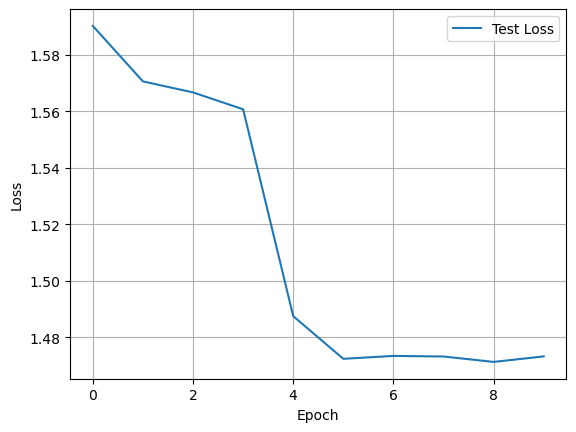

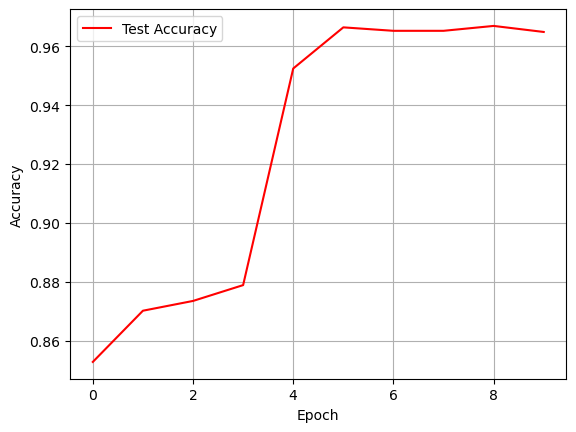

In [16]:
plt.plot(history['Test Loss'],label = 'Test Loss')
plt.legend(loc='best')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Loss')
matplotlib.pyplot.show()

matplotlib.pyplot.plot(history['Test Accuracy'],color = 'red',label = 'Test Accuracy')
matplotlib.pyplot.legend(loc='best')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Accuracy')
matplotlib.pyplot.show()

torch.save(net,'./model.pth')

In [15]:
import matplotlib.pyplot as plt

In [1]:
print(device)

NameError: name 'device' is not defined